In [7]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm
%matplotlib inline

import time
from datetime import date, timedelta

from google.oauth2.service_account import Credentials
import logging

from oauth2client.service_account import ServiceAccountCredentials

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

from powerbiclient import Report, models
from powerbiclient.authentication import MasterUserAuthentication
from powerbiclient.authentication import ServicePrincipalAuthentication
from powerbiclient.authentication import DeviceCodeLoginAuthentication
from powerbiclient.authentication import InteractiveLoginAuthentication
from io import StringIO
import ipywidgets
from ipywidgets import interact
import requests

In [2]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [3]:
# GBQ service account connection
credentials=Credentials.from_service_account_file('C:/Users/mncedisi.mncwabe/Documents/Connect to BQ/tal-production-data-4390ad039b75.json')

### DF - Aggregated by cust id

In [8]:
start_time = time.time()

query_rfm = '''

SELECT
     DISTINCT x.customer_id,
    /* CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
      END AS FY,
     FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,*/
     DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
     COUNT(DISTINCT x.order_id) AS Frequency,
     ROUND(SUM(x.order_item_sales),2) AS Monetary,
     IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration,
     SUM(x.Units) AS Units,
     COUNT(DISTINCT x.order_id) AS Nr_Orders,
     ROUND(SUM(x.order_item_sales),2) AS SalesEx,
FROM (
SELECT  
       DISTINCT customer_id,
       DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL

UNION ALL

SELECT 
        DISTINCT customer_id,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-05-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-05-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL) x
GROUP BY 1

'''
df = pd.read_gbq(query_rfm, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-05-13 14:57:26,699 : DEBUG : Requesting query... 
Query running...
2022-05-13 14:57:30,713 : DEBUG : Query running...
Job ID: ec7a823a-cfe9-41ca-9d94-6eaceaa848cc
2022-05-13 14:57:30,715 : DEBUG : Job ID: ec7a823a-cfe9-41ca-9d94-6eaceaa848cc
  Elapsed 6.18 s. Waiting...
2022-05-13 14:57:32,875 : INFO :   Elapsed 6.18 s. Waiting...
  Elapsed 7.25 s. Waiting...
2022-05-13 14:57:33,948 : INFO :   Elapsed 7.25 s. Waiting...
  Elapsed 8.34 s. Waiting...
2022-05-13 14:57:35,044 : INFO :   Elapsed 8.34 s. Waiting...
  Elapsed 9.43 s. Waiting...
2022-05-13 14:57:36,133 : INFO :   Elapsed 9.43 s. Waiting...
  Elapsed 10.52 s. Waiting...
2022-05-13 14:57:37,220 : INFO :   Elapsed 10.52 s. Waiting...
  Elapsed 11.61 s. Waiting...
2022-05-13 14:57:38,305 : INFO :   Elapsed 11.61 s. Waiting...
  Elapsed 12.69 s. Waiting...
2022-05-13 14:57:39,388 : INFO :   Elapsed 12.69 s. Waiting...
  Elapsed 13.79 s. Waiting...
2022-05-13 14:57:40,489 : INFO :   Elapsed 13.79 s. Waiting

Downloading:   0%|          | 0/4430654 [00:00<?, ?rows/s]

Got 4430654 rows.

2022-05-13 15:02:54,367 : DEBUG : Got 4430654 rows.

Total time taken 327.68 s.
Finished at 2022-05-13 15:02:54.
2022-05-13 15:02:54,383 : INFO : Total time taken 327.68 s.
Finished at 2022-05-13 15:02:54.


--- 327.68674969673157 seconds ---


### DF1 - aggregated by FY, Divisions

In [6]:
start_time = time.time()

query_df1 = '''

SELECT 
       y.FY,y.RepeatPurchase,y.YearMonth, y.Division,y.Nr_Customers, y.SalesEx, y.Nr_Orders, y.Units,
       y.Nr_Orders/y.Nr_Customers AS FOS,y.Units/y.Nr_Orders AS AOU, y.SalesEx/y.Units AS AISP,
      y.SalesEx/y.Nr_Orders AS AOV
FROM
(
SELECT 
     FORMAT_DATETIME('%Y%m', Auth_Date) AS YearMonth,
     CASE WHEN 
        customer_seq > 1 THEN 'Repeat Customer'
       ELSE 'New Customer'
     END AS RepeatPurchase,
         CASE WHEN DATE(Auth_Date) >= '2019-04-01' AND DATE(Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(Auth_Date) >= '2020-04-01' AND DATE(Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(Auth_Date) >= '2021-04-01' AND DATE(Auth_Date) < '2022-04-01' THEN "FY22"
      END AS FY,
    Division,
    COUNT(DISTINCT customer_id) AS Nr_Customers,
    COUNT(DISTINCT order_id) AS Nr_Orders,
    SUM(SalesEx) AS SalesEx,
    SUM(Units) AS Units,
FROM (
    SELECT  *,
    RANK() OVER (PARTITION BY customer_id ORDER BY x.Auth_Date) AS customer_seq
    FROM
(
SELECT  
       DISTINCT customer_id,
       DATE(o.order_authed_timestamp) AS Auth_Date,
       bh.bh_division AS Division,
        o.order_id,
        oi.order_item_sales AS SalesEx,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL

UNION ALL

SELECT 
        DISTINCT customer_id,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        bh.bh_division AS Division,
        o.order_id,
        oi.order_item_sales AS SalesEx,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-05-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-05-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL) x)
    GROUP BY 1,2,3,4) y
    WHERE y.FY IS NOT NULL
'''
df1 = pd.read_gbq(query_df1, project_id='gcp-takealot', dialect='standard', credentials=credentials)

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-05-11 13:01:51,355 : DEBUG : Requesting query... 
Query running...
2022-05-11 13:01:55,342 : DEBUG : Query running...
Job ID: 97319e86-b39f-440c-bdd3-0f4dab33424e
2022-05-11 13:01:55,342 : DEBUG : Job ID: 97319e86-b39f-440c-bdd3-0f4dab33424e
  Elapsed 6.13 s. Waiting...
2022-05-11 13:01:57,482 : INFO :   Elapsed 6.13 s. Waiting...
  Elapsed 7.18 s. Waiting...
2022-05-11 13:01:58,530 : INFO :   Elapsed 7.18 s. Waiting...
  Elapsed 8.25 s. Waiting...
2022-05-11 13:01:59,608 : INFO :   Elapsed 8.25 s. Waiting...
  Elapsed 9.29 s. Waiting...
2022-05-11 13:02:00,642 : INFO :   Elapsed 9.29 s. Waiting...
  Elapsed 10.35 s. Waiting...
2022-05-11 13:02:01,705 : INFO :   Elapsed 10.35 s. Waiting...
  Elapsed 11.41 s. Waiting...
2022-05-11 13:02:02,769 : INFO :   Elapsed 11.41 s. Waiting...
  Elapsed 12.51 s. Waiting...
2022-05-11 13:02:03,863 : INFO :   Elapsed 12.51 s. Waiting...
  Elapsed 13.61 s. Waiting...
2022-05-11 13:02:04,967 : INFO :   Elapsed 13.61 s. Waiting

--- 129.99666237831116 seconds ---


### DF2 - for customer cohorts

In [14]:
start_time = time.time()

query_df2 = '''

/* create the first purchase date and calculate the month order - # of months after first purchase */

SELECT y.first_purchase, y.month_order,y.Customers, y.Nr_Orders, y.SalesEx, y.Units,
       y.CohortCustomers, y.repurchase_rate,y.Nr_Orders/y.Customers AS FOS, ROUND(y.Units/y.Nr_Orders,1) AS AOU, 
       y.SalesEx/y.Units AS AISP,ROUND(y.SalesEx/y.Nr_Orders,0) AS AOV
    
FROM(
WITH t_first_purchase AS (
  SELECT 
  date,
  DATE_DIFF(date, first_purchase_date, MONTH) AS month_order,
  FORMAT_DATETIME('%Y%m', first_purchase_date) AS first_purchase,
  customer_id,
  order_item_sales,
  order_id,
  Units,
  FROM (
    SELECT 
    DATE(TIMESTAMP(Auth_Date)) AS date,
    customer_id,
    order_item_sales,
    order_id,
    Units,
    FIRST_VALUE(DATE(TIMESTAMP(Auth_Date))) OVER (PARTITION BY customer_id ORDER BY DATE(TIMESTAMP(Auth_Date))) AS first_purchase_date
    FROM 
    (
    SELECT *,
CASE WHEN customer_seq > 1 THEN 'Repeat Customer'
ELSE 'New Customer'
END AS RepeatPurchase
FROM (
    SELECT  *,
    RANK() OVER (PARTITION BY customer_id ORDER BY x.Auth_Date) AS customer_seq
    FROM
(
SELECT  
       DISTINCT customer_id,
       DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL

UNION ALL

SELECT 
        DISTINCT customer_id,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-05-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-05-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND o.order_authed_timestamp IS NOT NULL) x)  
    )
    )
  ),

/* aggregate customer count per first purchase cohort and month order */
t_agg AS (
  SELECT 
  first_purchase,
  month_order,
  COUNT(DISTINCT customer_id) AS Customers,
  COUNT(DISTINCT order_id) AS Nr_Orders,
  SUM(order_item_sales) AS SalesEx,
  SUM(Units) AS Units
  FROM 
  t_first_purchase
  GROUP BY first_purchase, month_order
),

/* repurchase rate */
 t_cohort AS (
  SELECT *,
  SAFE_DIVIDE(Customers, CohortCustomers) AS repurchase_rate
  FROM (
      SELECT *,
      FIRST_VALUE(Customers) OVER (PARTITION BY first_purchase ORDER BY month_order) AS CohortCustomers
      FROM t_agg
  )
 )
SELECT * FROM t_cohort 
ORDER BY first_purchase, month_order) y
GROUP BY 1,2,3,4,5,6,7,8

'''
df2 = pd.read_gbq(query_df2, project_id='gcp-takealot', dialect='standard', credentials=credentials)

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-05-13 15:04:16,075 : DEBUG : Requesting query... 
Query running...
2022-05-13 15:04:19,359 : DEBUG : Query running...
Job ID: b65098d4-a31a-43a5-9b0e-797d9e90c090
2022-05-13 15:04:19,359 : DEBUG : Job ID: b65098d4-a31a-43a5-9b0e-797d9e90c090
  Elapsed 6.5 s. Waiting...
2022-05-13 15:04:22,579 : INFO :   Elapsed 6.5 s. Waiting...
  Elapsed 7.58 s. Waiting...
2022-05-13 15:04:23,658 : INFO :   Elapsed 7.58 s. Waiting...
  Elapsed 8.68 s. Waiting...
2022-05-13 15:04:24,753 : INFO :   Elapsed 8.68 s. Waiting...
  Elapsed 10.55 s. Waiting...
2022-05-13 15:04:26,625 : INFO :   Elapsed 10.55 s. Waiting...
  Elapsed 11.64 s. Waiting...
2022-05-13 15:04:27,719 : INFO :   Elapsed 11.64 s. Waiting...
  Elapsed 12.74 s. Waiting...
2022-05-13 15:04:28,813 : INFO :   Elapsed 12.74 s. Waiting...
  Elapsed 13.82 s. Waiting...
2022-05-13 15:04:29,892 : INFO :   Elapsed 13.82 s. Waiting...
  Elapsed 14.91 s. Waiting...
2022-05-13 15:04:30,986 : INFO :   Elapsed 14.91 s. Waiting

--- 23.03759527206421 seconds ---


In [ ]:
start_time = time.time()

query_df3 = '''

SELECT y.customer_id, y.FY, y.YearMonth, y.Division, y.Department, y.Level1, y.Recency, y.Frequency, y.Monetary, y.Duration,
       y.Nr_Customers, y.GMV, y.Nr_Orders, y.Units,y.Nr_Orders/y.Nr_Customers AS FOS, 
       y.Units/y.Nr_Orders AS AOU, y.GMV/y.Units AS AISP, y.GMV/y.Nr_Orders AS AOV

FROM ( 
SELECT
     customer_id,
     CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
      END AS FY,
      FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,
      x.Division,
      x.Department,
       x.Level1,
      DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
      COUNT(DISTINCT x.order_id) AS Frequency,
      ROUND(SUM(x.order_item_sales),2) AS Monetary,
      IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration,
      COUNT(DISTINCT x.customer_id) AS Nr_Customers,
      ROUND(SUM(x.order_item_sales),2) AS GMV,
      COUNT(DISTINCT x.order_id) AS Nr_Orders,
      SUM(x.Units) AS Units 
FROM (      
SELECT  DISTINCT o.customer_id,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'

UNION ALL

SELECT DISTINCT o.customer_id,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-05-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-05-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped') x
    GROUP BY 1,2,3,4,3,4,5,6) y
    WHERE y.FY IS NOT NULL
'''
df3 = pd.read_gbq(query_df3, project_id='gcp-takealot', dialect='standard', credentials=credentials)

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-05-10 13:30:48,538 : DEBUG : Requesting query... 
Query running...
2022-05-10 13:30:51,864 : DEBUG : Query running...
Job ID: 25794da9-20f9-4e41-adb1-049cef2f39cc
2022-05-10 13:30:51,866 : DEBUG : Job ID: 25794da9-20f9-4e41-adb1-049cef2f39cc
  Elapsed 6.53 s. Waiting...
2022-05-10 13:30:55,066 : INFO :   Elapsed 6.53 s. Waiting...
  Elapsed 7.59 s. Waiting...
2022-05-10 13:30:56,127 : INFO :   Elapsed 7.59 s. Waiting...
  Elapsed 8.64 s. Waiting...
2022-05-10 13:30:57,182 : INFO :   Elapsed 8.64 s. Waiting...
  Elapsed 9.68 s. Waiting...
2022-05-10 13:30:58,214 : INFO :   Elapsed 9.68 s. Waiting...
  Elapsed 10.72 s. Waiting...
2022-05-10 13:30:59,253 : INFO :   Elapsed 10.72 s. Waiting...
  Elapsed 11.79 s. Waiting...
2022-05-10 13:31:00,331 : INFO :   Elapsed 11.79 s. Waiting...
  Elapsed 12.85 s. Waiting...
2022-05-10 13:31:01,390 : INFO :   Elapsed 12.85 s. Waiting...
  Elapsed 13.88 s. Waiting...
2022-05-10 13:31:02,420 : INFO :   Elapsed 13.88 s. Waiting

In [11]:
df.head()

,customer_id,Recency,Frequency,Monetary,Duration,Units,Nr_Orders,SalesEx
0,935005,20,88,83928.70,1091,338,88,83928.70
1,2087719,32,60,52908.70,1070,221,60,52908.70
2,2616158,299,19,13942.61,763,48,19,13942.61
3,5343697,89,35,101676.52,857,151,35,101676.52
4,175943,5,58,95578.26,1104,122,58,95578.26


In [12]:
df1.head()

,FY,RepeatPurchase,YearMonth,Division,Nr_Customers,SalesEx,Nr_Orders,Units,FOS,AOU,AISP,AOV
0,FY20,Repeat Customer,202003,Electronics,103478,1.429970e+08,123913,214173,1.197482,1.728414,667.670723,1154.011619
1,FY22,Repeat Customer,202202,Electronics,245320,3.384324e+08,298799,501440,1.217997,1.678185,674.921107,1132.642479
2,FY21,Repeat Customer,202006,Lifestyle,91614,5.699481e+07,107496,158353,1.173358,1.473106,359.922529,530.204028
3,FY22,Repeat Customer,202110,Consumables,314045,1.975516e+08,410615,999593,1.307504,2.434380,197.632024,481.111474
4,FY21,Repeat Customer,202101,Consumables,291481,1.906135e+08,397567,945373,1.363955,2.377896,201.627862,479.450097


In [241]:
df1_2 = df1.drop('Division',axis=1)
df1_3 = df1.drop('FY',axis=1)

In [242]:
df1_2.head()

,FY,RepeatPurchase,YearMonth,Nr_Customers,SalesEx,Nr_Orders,Units,FOS,AOU,AISP,AOV
0,FY22,Repeat Customer,202108,332335,218316949.13,444399,1101799,1.34,2.48,198.15,491.26
1,FY22,Repeat Customer,202108,297275,367288115.65,394211,759001,1.33,1.93,483.91,931.70
2,FY22,Repeat Customer,202106,305154,199407686.96,404978,994916,1.33,2.46,200.43,492.39
3,FY22,Repeat Customer,202109,308676,195836373.91,403976,1002164,1.31,2.48,195.41,484.77
4,FY22,Repeat Customer,202201,337191,418540620.00,450519,861138,1.34,1.91,486.03,929.02


In [243]:
df1_3.head()

,RepeatPurchase,YearMonth,Division,Nr_Customers,SalesEx,Nr_Orders,Units,FOS,AOU,AISP,AOV
0,Repeat Customer,202108,Consumables,332335,218316949.13,444399,1101799,1.34,2.48,198.15,491.26
1,Repeat Customer,202108,Home,297275,367288115.65,394211,759001,1.33,1.93,483.91,931.70
2,Repeat Customer,202106,Consumables,305154,199407686.96,404978,994916,1.33,2.46,200.43,492.39
3,Repeat Customer,202109,Consumables,308676,195836373.91,403976,1002164,1.31,2.48,195.41,484.77
4,Repeat Customer,202201,Home,337191,418540620.00,450519,861138,1.34,1.91,486.03,929.02


In [15]:
df2.head()

,first_purchase,month_order,Customers,Nr_Orders,SalesEx,Units,CohortCustomers,repurchase_rate,FOS,AOU,AISP,AOV
0,201904,0,271857,368877,382515047.034780398,967490,271857,1.000000,1.356879,2.6,395.368476196,1037.000000000
1,201904,1,93725,158778,172170099.156520981,476862,271857,0.344758,1.694084,3.0,361.048058257,1084.000000000
2,201904,2,84163,137110,148664769.634780988,414483,271857,0.309586,1.629101,3.0,358.675192070,1084.000000000
3,201904,3,92167,157179,173803946.878258893,468150,271857,0.339028,1.705372,3.0,371.256962252,1106.000000000
4,201904,4,84714,142345,154730145.217389444,408908,271857,0.311612,1.680301,2.9,378.398430007,1087.000000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431850 entries, 0 to 4431849
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   Recency      int64  
 2   Frequency    int64  
 3   Monetary     float64
 4   Duration     int64  
 5   Units        int64  
 6   Nr_Orders    int64  
 7   SalesEx      float64
dtypes: float64(2), int64(6)
memory usage: 270.5 MB


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FY            229 non-null    object 
 1   YearMonth     229 non-null    object 
 2   Division      229 non-null    object 
 3   Recency       229 non-null    int64  
 4   Frequency     229 non-null    int64  
 5   Monetary      229 non-null    float64
 6   Duration      229 non-null    int64  
 7   Nr_Customers  229 non-null    int64  
 8   SalesEx       229 non-null    float64
 9   Nr_Orders     229 non-null    int64  
 10  Units         229 non-null    int64  
 11  FOS           229 non-null    float64
 12  AOU           229 non-null    float64
 13  AISP          229 non-null    float64
 14  AOV           229 non-null    float64
dtypes: float64(6), int64(6), object(3)
memory usage: 27.0+ KB


In [16]:
df['Monetary'] = df['Monetary'].astype(float)
df['SalesEx'] = df['SalesEx'].astype(float)

#df1['Monetary'] = df1['Monetary'].astype(float)
df1['SalesEx'] = df1['SalesEx'].astype(float)
df1['AISP'] = df1['AISP'].astype(float)
df1['AOV'] = df1['AOV'].astype(float)

df2['SalesEx'] = df2['SalesEx'].astype(float)
df2['AOV'] = df2['AOV'].astype(int)

### Outlier Analysis

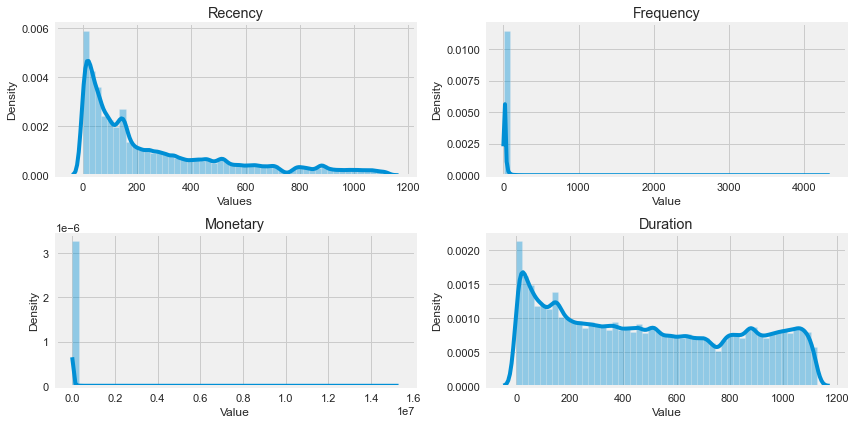

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
sns.distplot(df.Recency, ax=ax[0][0])
ax[0][0].set_title('Recency')
ax[0][0].set_xlabel('Values')
sns.distplot(df.Frequency, ax=ax[0][1])
ax[0][1].set_title('Frequency')
ax[0][1].set_xlabel('Value')
sns.distplot(df.Monetary, ax=ax[1][0])
ax[1][0].set_title('Monetary')
ax[1][0].set_xlabel('Value')
sns.distplot(df.Duration, ax=ax[1][1])
ax[1][1].set_title('Duration')
ax[1][1].set_xlabel('Value')
plt.tight_layout()
plt.show()

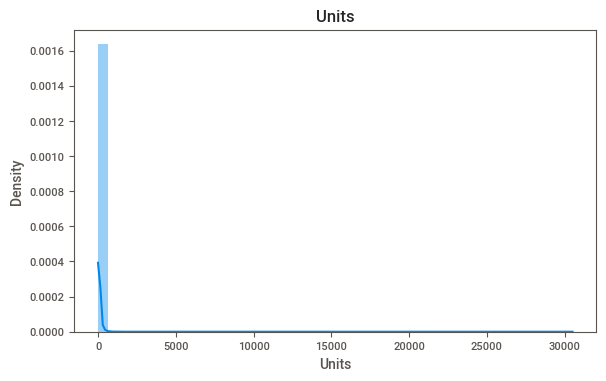

In [44]:
sns.distplot(df.Units)
plt.title('Units');

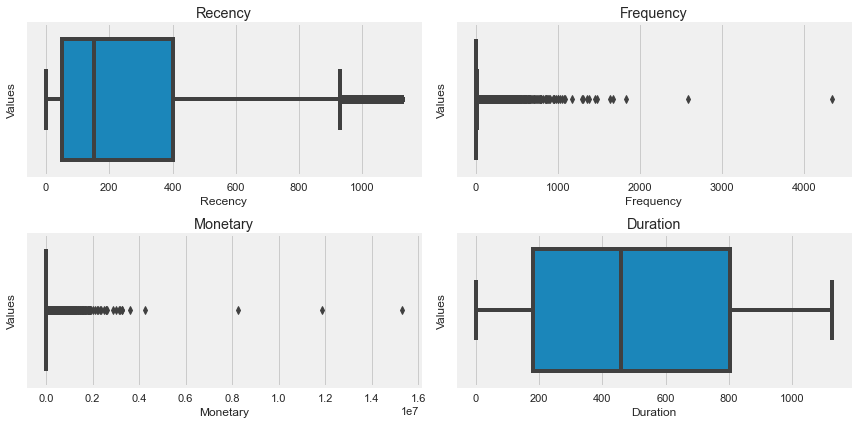

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
sns.boxplot(df.Recency, orient='v', ax=ax[0][0])
ax[0][0].set_title('Recency')
ax[0][0].set_ylabel('Values')
ax[0][0].set_yticklabels([])
sns.boxplot(df.Frequency, orient='v', ax=ax[0][1])
ax[0][1].set_title('Frequency')
ax[0][1].set_ylabel('Values')
ax[0][1].set_yticklabels([])
sns.boxplot(df.Monetary, orient='v', ax=ax[1][0])
ax[1][0].set_title('Monetary')
ax[1][0].set_ylabel('Values')
ax[1][0].set_yticklabels([])
sns.boxplot(df.Duration, orient='v', ax=ax[1][1])
ax[1][1].set_title('Duration')
ax[1][1].set_ylabel('Values')
ax[1][1].set_yticklabels([])
plt.tight_layout()
plt.show()

- Some outliers exist in the distribution of the Monetary and Frequency

In [257]:
# Find the outlier customers
df_outlier = df[['Recency','Frequency','Monetary','Duration','Units']]
Q1 = df_outlier.quantile(0.25)
Q3 = df_outlier.quantile(0.75)
IQR = Q3 - Q1
# filter the dataset with the IQR
df_out = df_outlier[((df_outlier < (Q1 - 1.5 * IQR)) |(df_outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out

,Recency,Frequency,Monetary,Duration,Units
0,5,37,21577.39,1011,89
1,51,19,16634.78,895,45
2,5,81,116296.09,1071,477
3,46,35,29133.91,623,101
4,25,38,65847.83,1095,125
...,...,...,...,...,...
4431820,5,26,9626.96,571,29
4431827,586,22,4477.39,523,29
4431833,74,11,18830.43,817,29
4431839,429,18,72308.70,647,29


In [266]:
"""
Upper bound for each RFMD variable
Monetary = 16.8k, This means that the customers who spend more than 16.8K are outliers (High Spenders)
Frequency = 18, Customers who make more than 18 transactions are outliers ('for keeps')
Recency = 928, Customers who last purchased 2 years ago are outliers (probably will never buy again)
"""
print(Q3 + 1.5 * IQR)

Recency       928.50
Frequency      18.50
Monetary    16888.26
Duration     1739.00
Units          39.50
dtype: float64


In [320]:
# descriptive stats - overall population
pd.set_option('display.float_format', lambda s: '%.2f' % s)
df[['Recency','Frequency','Monetary','Duration','Units','Nr_Orders']].apply(lambda x: x.describe([.25,.5,.75]))

,Recency,Frequency,Monetary,Duration,Units,Nr_Orders
count,4431850.00,4431850.00,4431850.00,4431850.00,4431850.00,4431850.00
mean,263.42,7.23,7745.10,495.05,20.11,7.23
std,277.78,13.85,23335.32,342.04,61.51,13.85
min,0.00,1.00,0.87,0.00,1.00,1.00
25%,51.00,1.00,477.39,179.00,2.00,1.00
50%,152.00,3.00,1866.09,459.00,5.00,3.00
75%,402.00,8.00,7041.74,803.00,17.00,8.00
max,1125.00,4343.00,15286681.74,1125.00,30500.00,4343.00


In [319]:
# once-off purchasers descriptive stats
"""there are 38% once-off purchasers in the last 3 years, 
   their average spending is low and their average recency(423)is 16 months (which is more than the recency of 
   the overall pop - 7 months). This group average less than 2 units. 
   Chances of these customers making a repeeat purchase are low.
"""
df[['Recency','Frequency','Monetary','Duration','Units','Nr_Orders']][df.Frequency==1].describe()

,Recency,Frequency,Monetary,Duration,Units,Nr_Orders
count,1487249.00,1487249.00,1487249.00,1487249.00,1487249.00,1487249.00
mean,423.02,1.00,717.41,423.02,1.87,1.00
std,316.20,0.00,1728.40,316.20,2.84,0.00
min,0.00,1.00,0.87,0.00,1.00,1.00
25%,151.00,1.00,164.35,151.00,1.00,1.00
50%,358.00,1.00,329.57,358.00,1.00,1.00
75%,651.00,1.00,633.91,651.00,2.00,1.00
max,1125.00,1.00,867915.65,1125.00,797.00,1.00


In [315]:
# # descriptive stats - excluding once off purchasers
"""
the average recency without the once-off purchasers is 4 months (below the average recency of the once-off purchasers)
with a much higher average spending too. The average duration of this group is over a year. 
Average units without the once-off purchasers is also high
"""
pd.set_option('display.float_format', lambda s: '%.2f' % s)
df[['Recency','Frequency','Monetary','Duration','Units','Nr_Orders']][df.Frequency>1].apply(lambda x: x.describe([.25,.5,.75]))

,Recency,Frequency,Monetary,Duration,Units,Nr_Orders
count,2944601.00,2944601.00,2944601.00,2944601.00,2944601.00,2944601.00
mean,182.80,10.38,11294.61,531.43,29.32,10.38
std,215.11,16.10,27937.74,348.77,73.74,16.10
min,0.00,2.00,1.74,0.00,2.00,2.00
25%,33.00,3.00,1583.48,208.00,5.00,3.00
50%,100.00,5.00,4326.96,520.00,11.00,5.00
75%,248.00,12.00,11743.48,851.00,29.00,12.00
max,1125.00,4343.00,15286681.74,1125.00,30500.00,4343.00


In [316]:
# 'High Spenders' - outlier customers
"""
Over 10% customers spend more than the 16.8k 
with an average frequency 30.
The recency of this group is also low (last purchased 60 days ago)
"""
df[['Recency','Frequency','Monetary','Duration','Units','Nr_Orders']][df.Monetary>16800].describe()

,Recency,Frequency,Monetary,Duration,Units,Nr_Orders
count,522872.00,522872.00,522872.00,522872.00,522872.00,522872.00
mean,68.44,30.42,42521.01,874.73,101.73,30.42
std,108.70,29.14,55981.55,237.61,152.45,29.14
min,0.00,1.00,16800.87,0.00,1.00,1.00
25%,10.00,15.00,21666.96,772.00,40.00,15.00
50%,32.00,24.00,29635.65,958.00,70.00,24.00
75%,80.00,37.00,46383.48,1053.00,119.00,37.00
max,1124.00,4343.00,15286681.74,1125.00,30500.00,4343.00


In [317]:
# Most frequent purchasers - 10%
"""
Customers with more than the upper bound frequency (18) have a low recency, high monetary, Duration and Units.
These customers are very associated with our business and will highly likely make a repeat purchase

"""
df[['Recency','Frequency','Monetary','Duration','Units','Nr_Orders']][df.Frequency>18].describe()

,Recency,Frequency,Monetary,Duration,Units,Nr_Orders
count,417338.00,417338.00,417338.00,417338.00,417338.00,417338.00
mean,47.11,37.16,43908.35,935.01,120.34,37.16
std,71.33,29.77,62340.27,183.74,164.54,29.77
min,0.00,19.00,86.96,1.00,19.00,19.00
25%,8.00,22.00,19616.52,865.00,56.00,22.00
50%,25.00,29.00,30703.48,999.00,84.00,29.00
75%,58.00,41.00,50506.96,1067.00,136.00,41.00
max,1122.00,4343.00,15286681.74,1125.00,30500.00,4343.00


In [216]:
top_cust = df
cumsum = (top_cust["SalesEx"]/top_cust["SalesEx"].sum()).sort_values().cumsum()
top_cust["Top_20"] = pd.Series("Other", index=cumsum.index).where(cumsum <= 0.2, "Top20%")

In [318]:
"""
956K (20%) Customers account for 80% GMV.
These customers also have a low average recency, high frequency, units and duration 
indicating high assocation with the business
"""
top_cust[['Recency','Frequency','Monetary','Duration','Units','Nr_Orders']][top_cust.Top_20=="Top20%"].describe()

,Recency,Frequency,Monetary,Duration,Units,Nr_Orders
count,955814.00,955814.00,955814.00,955814.00,955814.00,955814.00
mean,93.71,22.13,28729.54,798.27,69.73,22.13
std,137.56,23.86,44119.88,272.94,118.97,23.86
min,0.00,1.00,8625.22,0.00,1.00,1.00
25%,16.00,10.00,12173.04,634.00,24.00,10.00
50%,46.00,16.00,18260.87,878.00,43.00,16.00
75%,113.00,26.00,31573.91,1019.00,79.00,26.00
max,1125.00,4343.00,15286681.74,1125.00,30500.00,4343.00


In [304]:
def rec(i):
    if i >=0 and i <30:
        return "0-1 month"
    elif i>=30 and i<60:
        return "1-2 months"
    elif i>=60 and i<90:
        return "2-3 months"
    elif i>=90 and i<120:
        return "3-4 months"
    elif i>=120 and i<180:
        return "4-6 months"
    elif i>=180 and i<240:
        return "6-8 months"
    elif i>=240 and i<300:
        return "8-10 months"
    elif i>=300 and i<360:
        return "10-12 months"
    else:
        return "12+ months"

In [307]:
def freq(i):
    if i >=1 and i <5:
        return "1-5"
    elif i>=5 and i<10:
        return "5-10"
    elif i>=10 and i<20:
        return "10-20"
    elif i>=20 and i<30:
        return "20-30"
    elif i>=30 and i<40:
        return "30-40"
    elif i>=40 and i<50:
        return "40-50"
    elif i>=50 and i<60:
        return "50-60"
    elif i>=60 and i<70:
        return "60-70"
    else:
        return "70+"

In [311]:
def dur(i):
    if i >=0 and i <30:
        return "0-1 Month"
    elif i>=30 and i<60:
        return "1-2 months"
    elif i>=60 and i<90:
        return "2-3 months"
    elif i>=90 and i<120:
        return "3-4 months"
    elif i>=120 and i<180:
        return "4-6 months"
    elif i>=180 and i<240:
        return "6-8 months"
    elif i>=240 and i<300:
        return "8-10 months"
    elif i>=300 and i<360:
        return "10-12 months"
    else:
        return "12+ months"

In [336]:
df_rec = df
df_rec['rec_cat'] = df_rec['Recency'].apply(rec) 
df_rec['freq_cat'] = df_rec['Frequency'].apply(freq) 
df_rec['dur_cat'] = df_rec['Duration'].apply(dur) 
df_rec_grouped = df_rec.groupby(['rec_cat','freq_cat','dur_cat']).agg(GMV=('SalesEx', 'sum'), Nr_Cust=('customer_id', 'count'))

In [265]:
#fy20 = df[df['FY']=='FY20']
#fy21 = df[df['FY']=='FY21']
#fy22 = df[df['FY']=='FY22']

In [102]:
import sweetviz as sv

analyze_df = df[['Recency','Frequency','Monetary','Duration','Units']]
analyze_report = sv.analyze(analyze_df)

                                             |          | [  0%]   00:00 -> (? left)


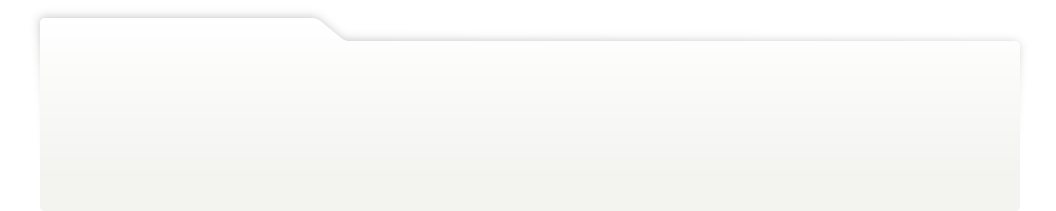
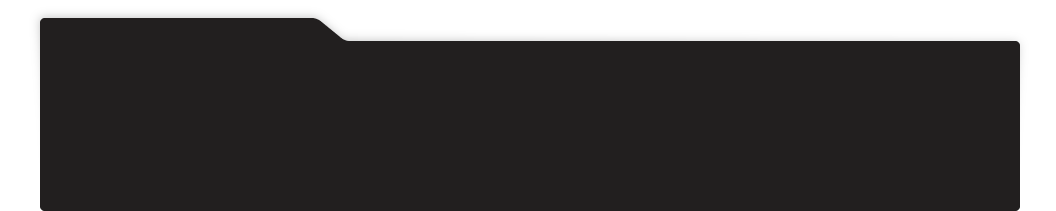
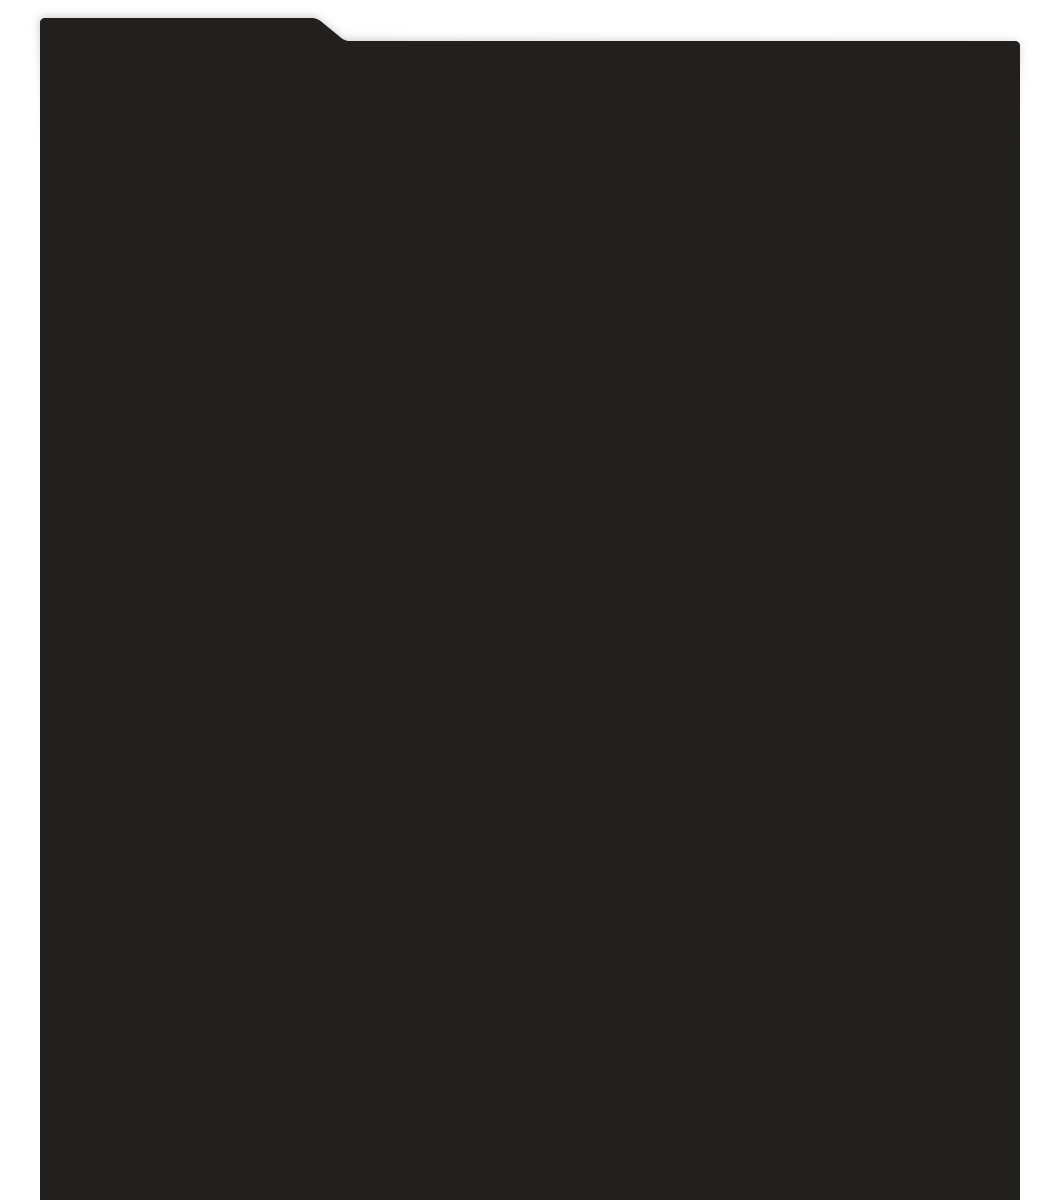
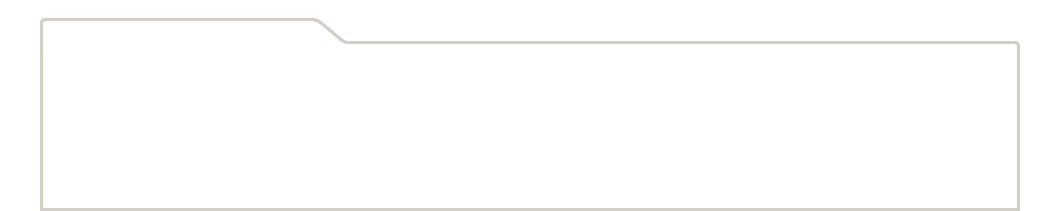
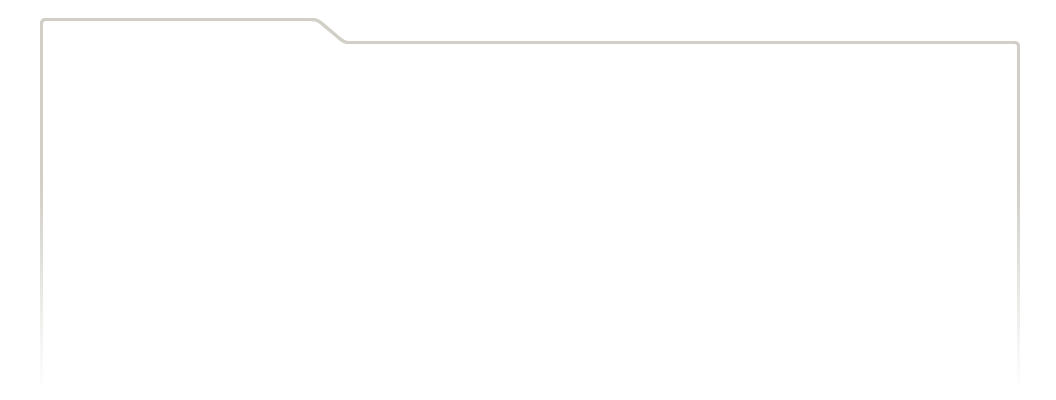
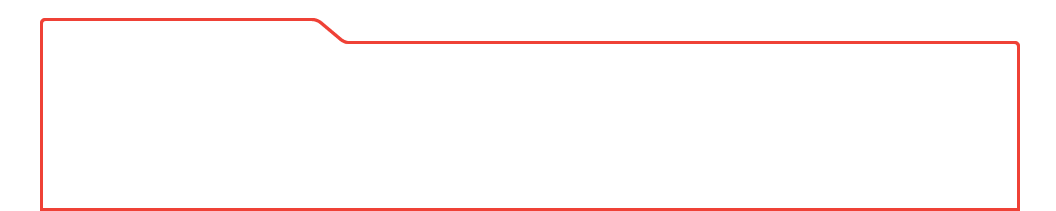
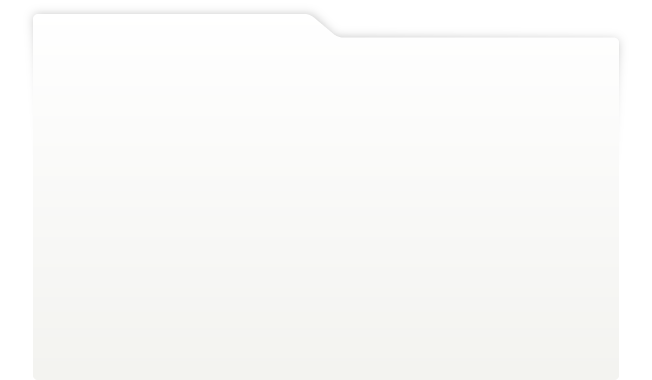
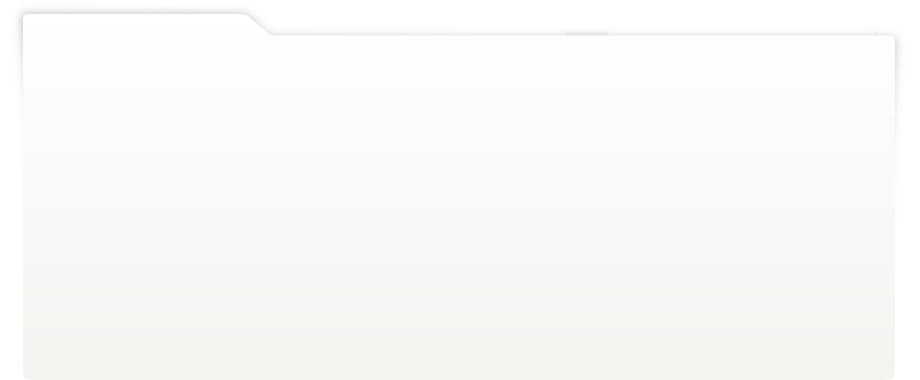
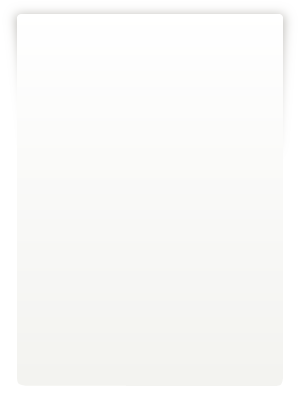
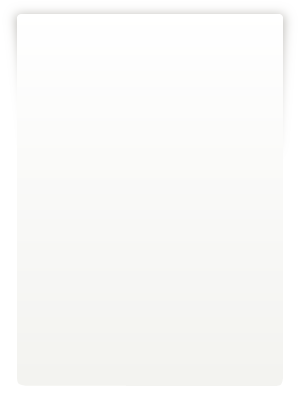
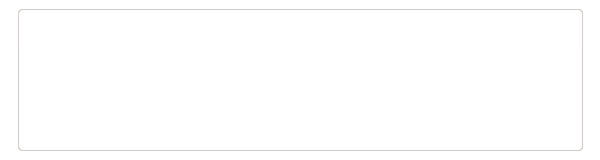
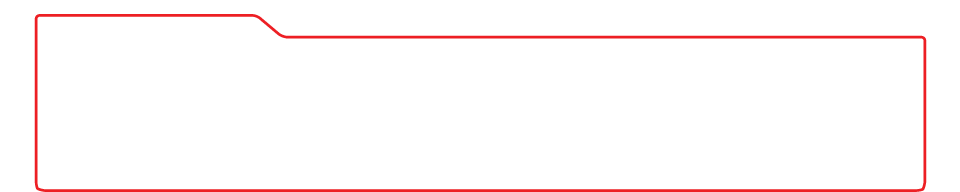
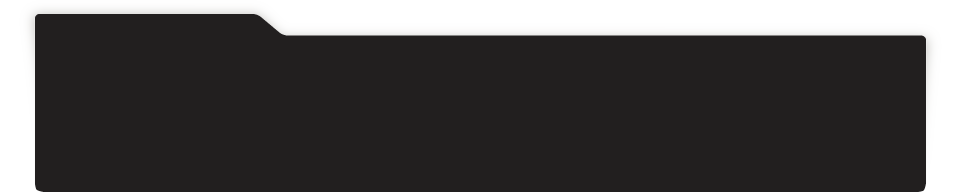
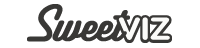
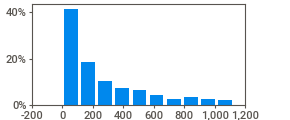
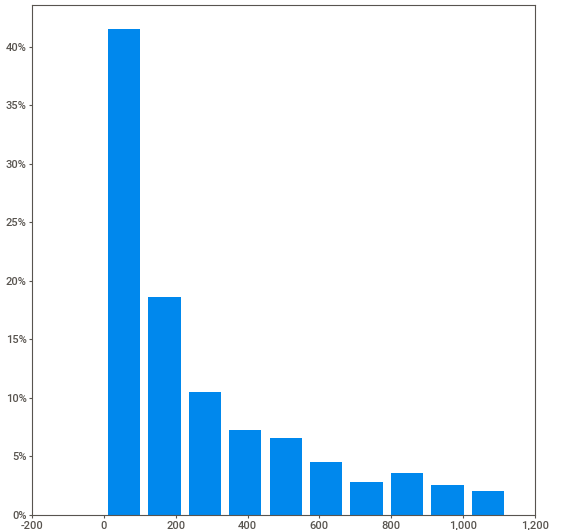
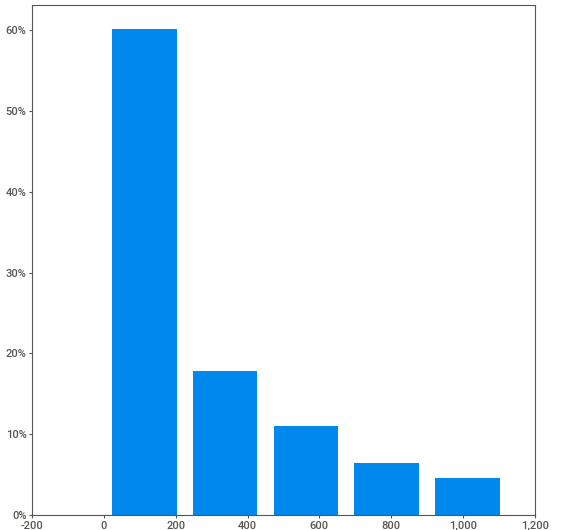
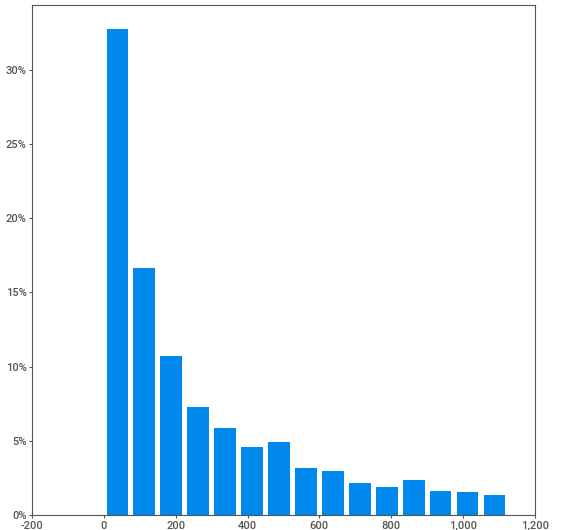
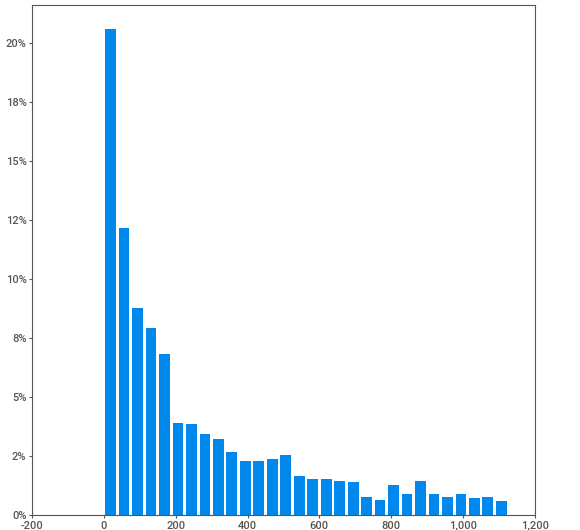
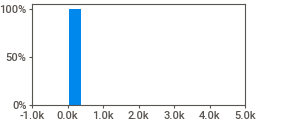
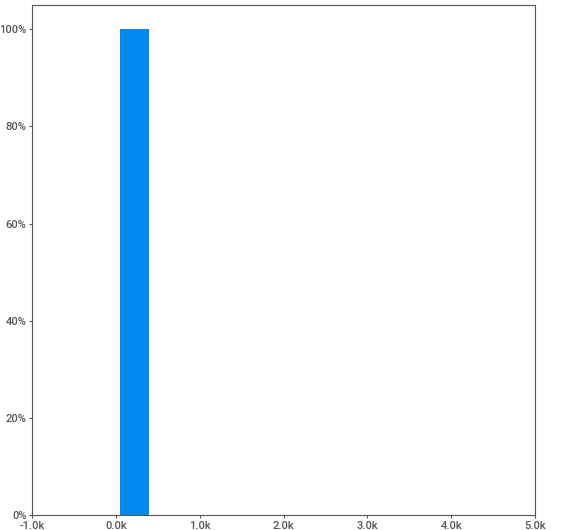
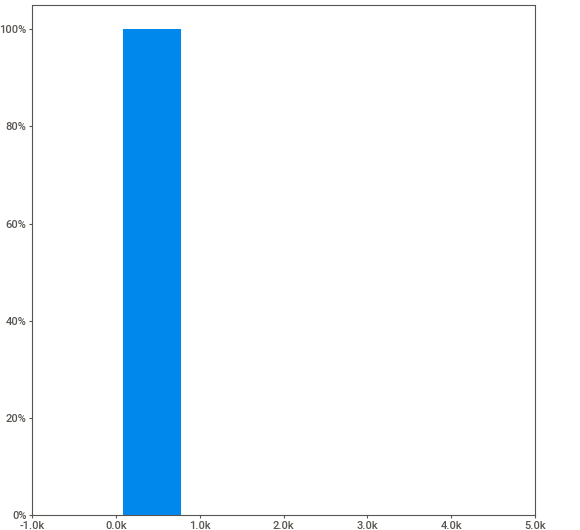
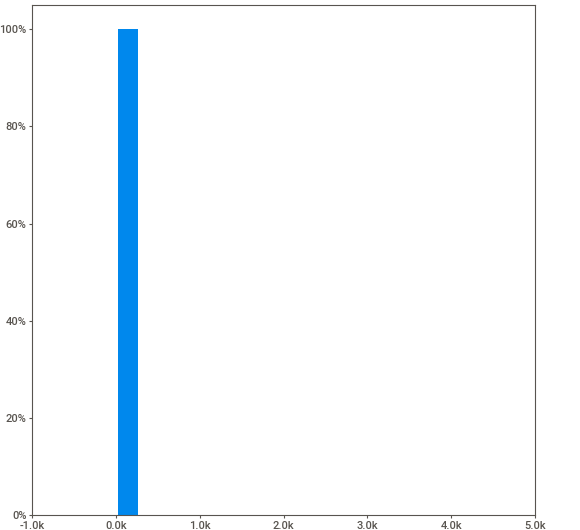
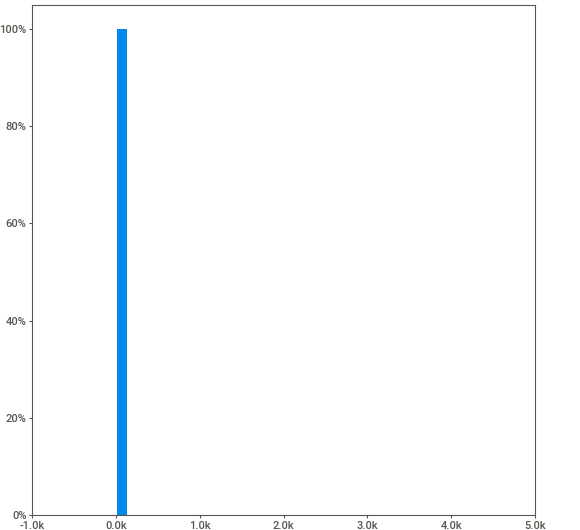
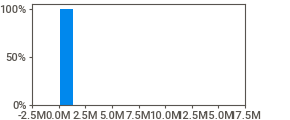
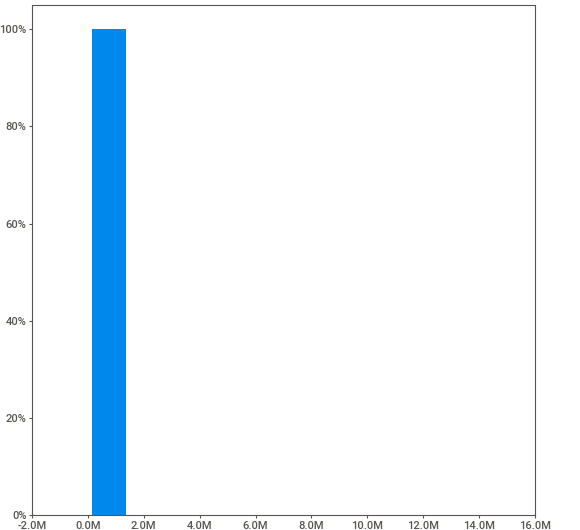
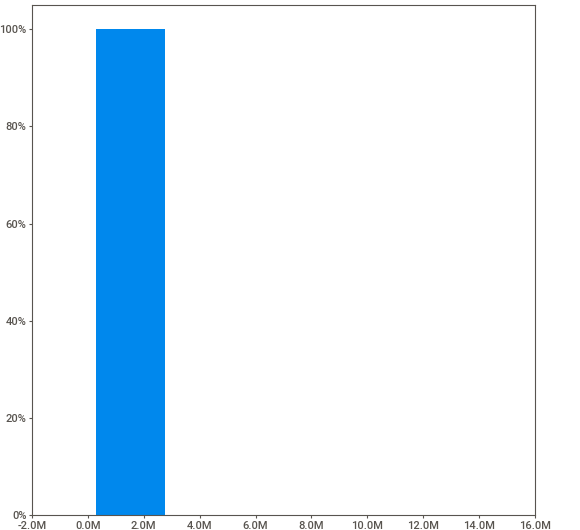
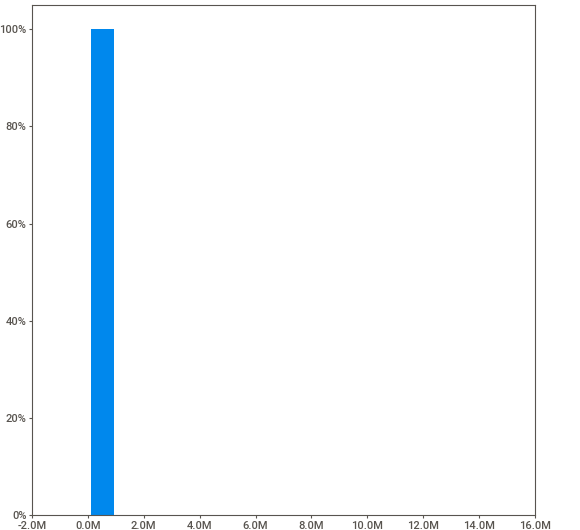
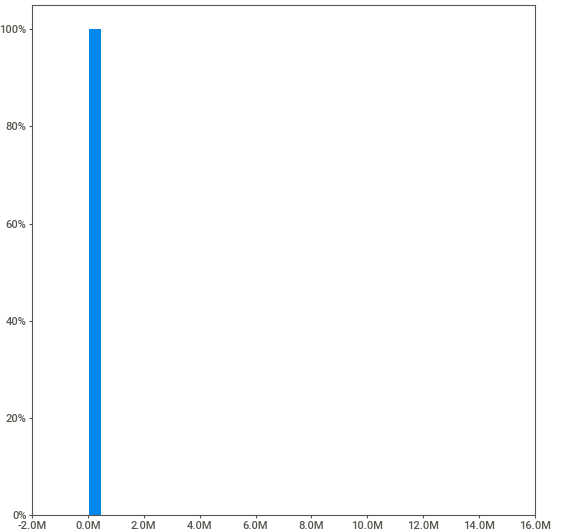
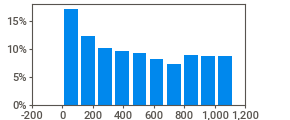
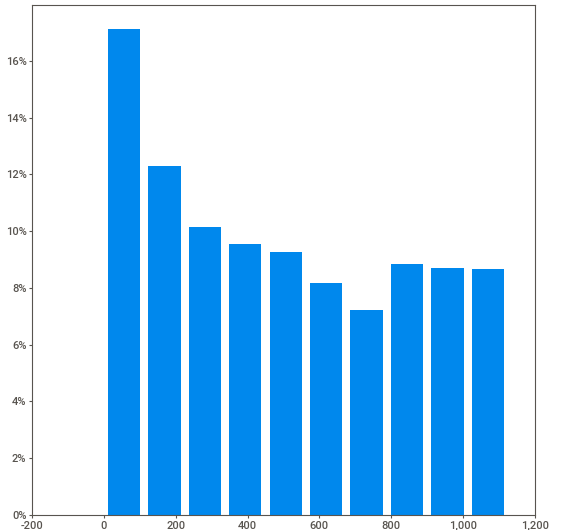
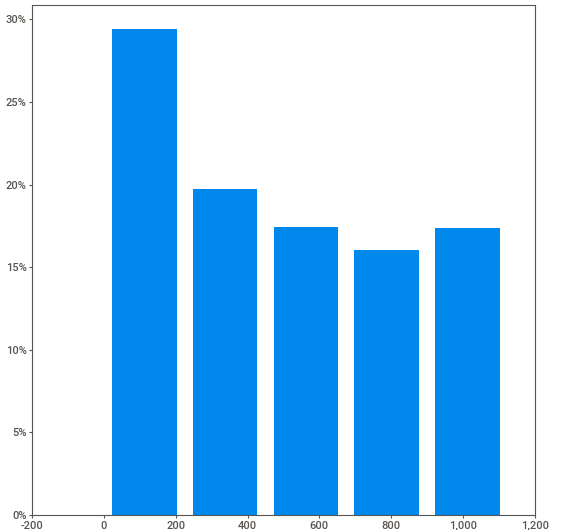
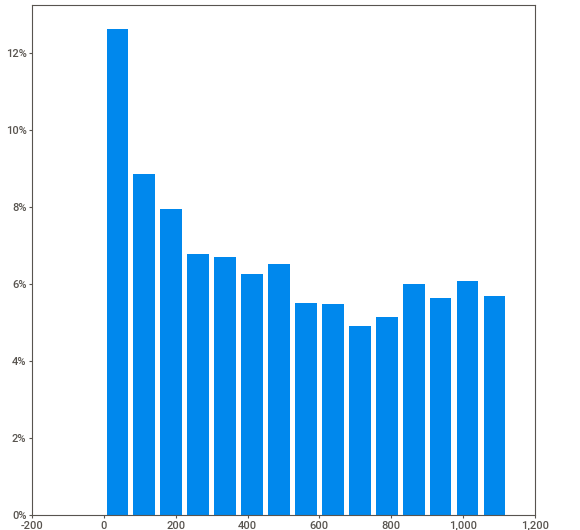
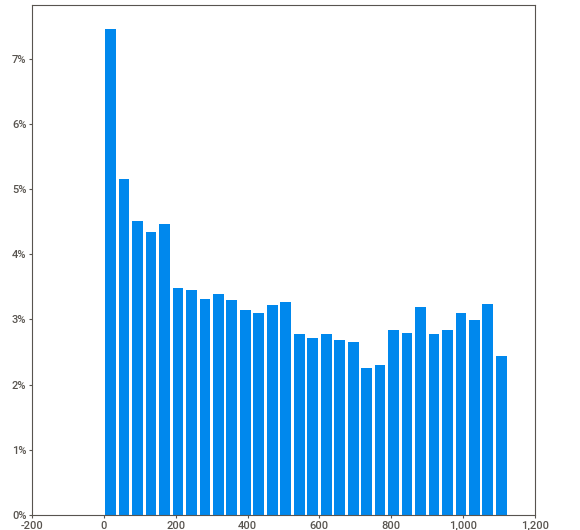
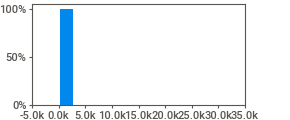
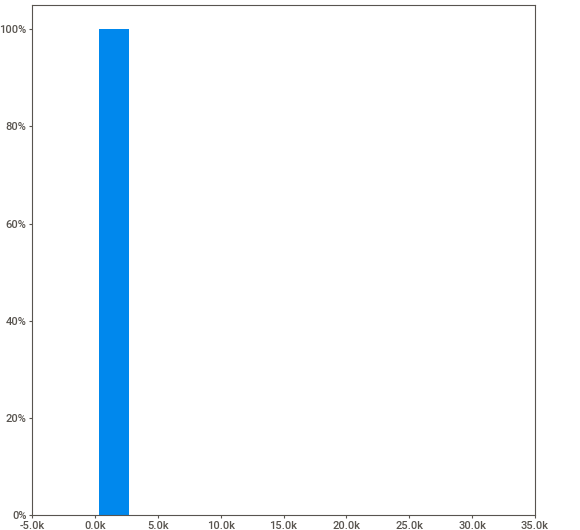
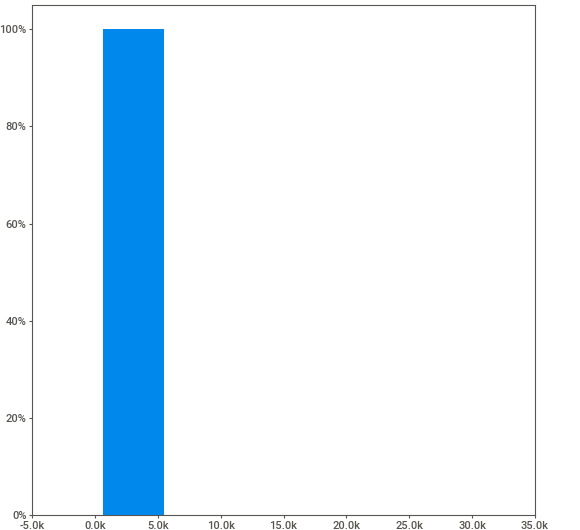
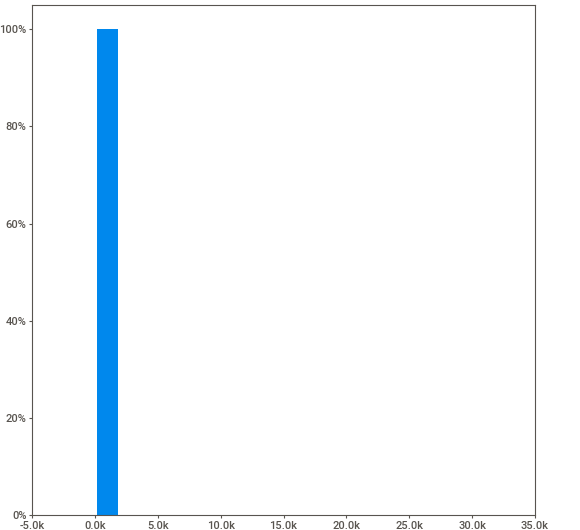
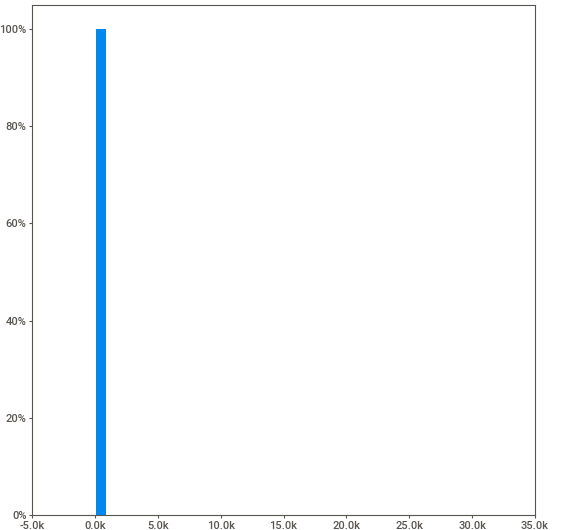
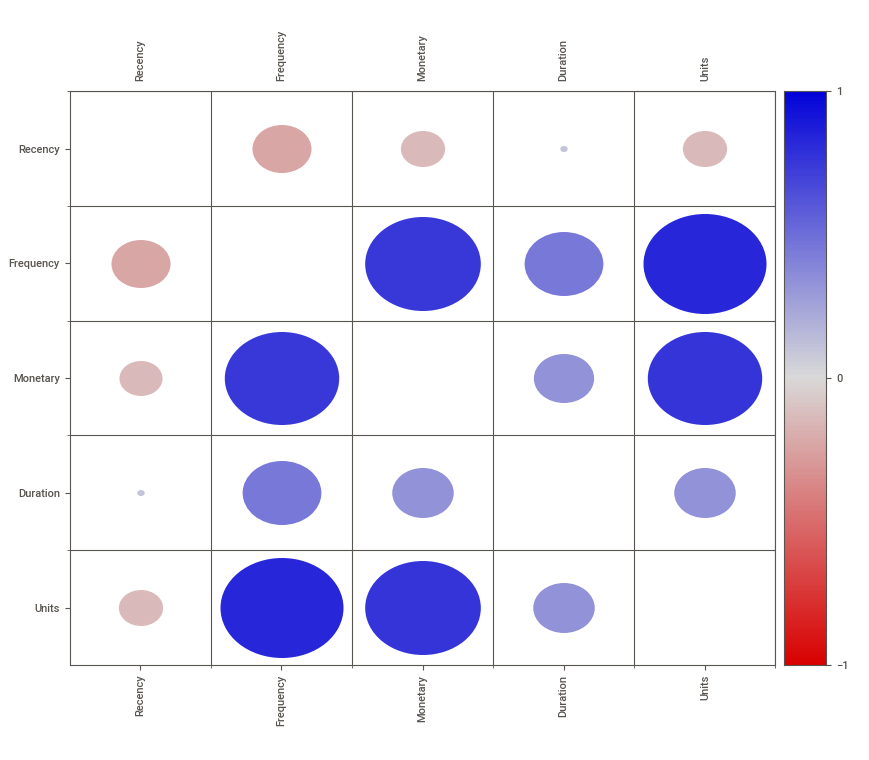
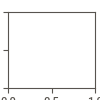

In [103]:
analyze_report.show_notebook()

### Correlation

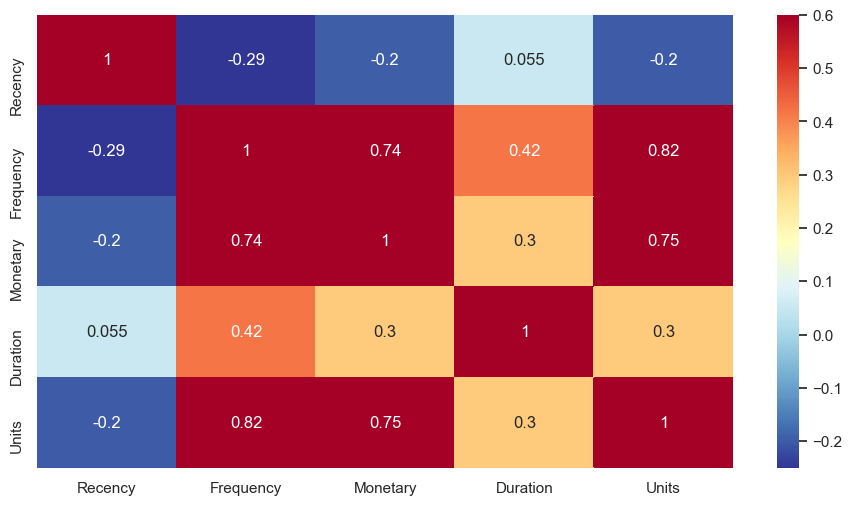

In [334]:
data= df[['Recency','Frequency','Monetary','Duration','Units']]
plt.figure(figsize = (10,6))
sns.heatmap(data.corr(method="pearson"), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plot.set_xticklabels(plot.get_xmajorticklabels(),fontsize = 13)
plot.set_yticklabels(plot.get_ymajorticklabels(),fontsize = 13)
plt.show()

- There's a strong positive correlation between Frequency and Monetary: customers who buy more often tend to spend more money
- Negative correlation between Recency and Monetary, which means customers who have purchased more recent tend to spend more
- Negative correlation between Recency and Frequency, means that customers who have purchased recently tend to purchase more often
- Positive correlation between Duration and Monetary: the more days between a customer's first and last order the more money they spend
- Negative correlation between Units and Recency indicates that customers who purchased more recent tend to buy more units in their orders

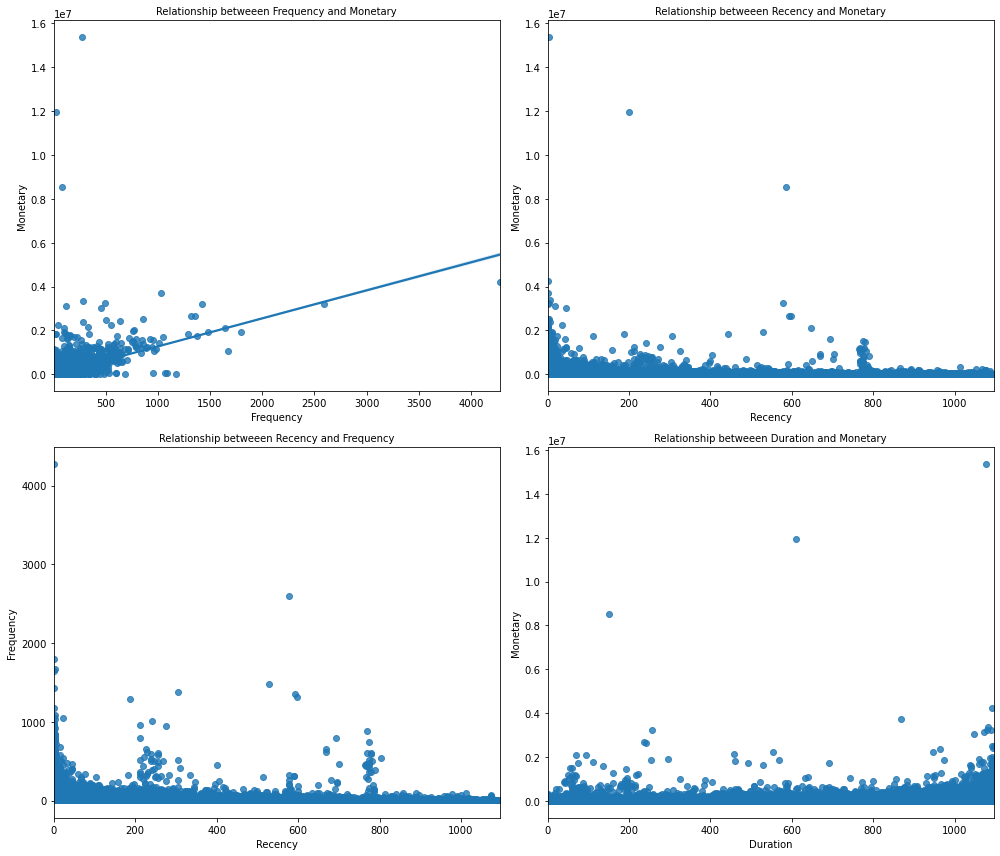

--- 2482.2413947582245 seconds ---


In [203]:
start_time = time.time()
rfm = df
#rfm.set_index('customer_id', inplace=True)
fig, ax = plt.subplots(2, 2, figsize=(14,12))
#fig.suptitle("Relationship between RFMD variables", fontsize=16)
# plot the regrassion line to highlight the correlation
sns.regplot(rfm.Frequency, rfm.Monetary,ax=ax[0][0])
ax[0][0].set_title('Relationship betweeen Frequency and Monetary',fontsize=12)
ax[0][0].set_xlabel('Frequency')
ax[0][0].set_ylabel('Monetary')
sns.regplot(rfm.Recency, rfm.Monetary,ax=ax[0][1])
ax[0][1].set_title('Relationship betweeen Recency and Monetary',fontsize=12)
ax[0][1].set_xlabel('Recency')
ax[0][1].set_ylabel('Monetary')
sns.regplot(rfm.Recency, rfm.Frequency,ax=ax[1][0])
ax[1][0].set_title('Relationship betweeen Recency and Frequency',fontsize=12)
ax[1][0].set_xlabel('Recency')
ax[1][0].set_ylabel('Frequency')
sns.regplot(rfm.Duration, rfm.Monetary,ax=ax[1][1])
ax[1][1].set_title('Relationship betweeen Duration and Monetary',fontsize=12)
ax[1][1].set_xlabel('Duration')
ax[1][1].set_ylabel('Monetary')
plt.tight_layout()
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

## Customer Cohorts 

#### repeat purchases

In [164]:
cohort_counts = df2.pivot(index="first_purchase",
                                  columns="month_order",
                                  values="repurchase_rate")
cohort_counts

month_order,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
first_purchase,,,,,,,,,,,,,,,,,,,,,
201904,1.00,0.34,0.31,0.34,0.31,0.30,0.32,0.38,0.35,0.33,...,0.37,0.37,0.35,0.35,0.42,0.40,0.37,0.34,0.36,0.33
201905,1.00,0.24,0.26,0.24,0.22,0.24,0.31,0.28,0.25,0.24,...,0.30,0.28,0.29,0.36,0.33,0.31,0.28,0.29,0.27,NaN
201906,1.00,0.23,0.20,0.19,0.20,0.26,0.24,0.21,0.19,0.16,...,0.24,0.25,0.31,0.30,0.27,0.24,0.25,0.23,NaN,NaN
201907,1.00,0.19,0.17,0.18,0.23,0.21,0.19,0.18,0.14,0.07,...,0.22,0.28,0.27,0.24,0.21,0.23,0.21,NaN,NaN,NaN
201908,1.00,0.17,0.17,0.21,0.19,0.17,0.16,0.13,0.06,0.21,...,0.25,0.24,0.22,0.20,0.21,0.19,NaN,NaN,NaN,NaN
201909,1.00,0.18,0.21,0.19,0.16,0.15,0.12,0.06,0.20,0.19,...,0.23,0.21,0.19,0.20,0.18,NaN,NaN,NaN,NaN,NaN
201910,1.00,0.22,0.18,0.15,0.14,0.11,0.05,0.19,0.18,0.18,...,0.20,0.18,0.19,0.17,NaN,NaN,NaN,NaN,NaN,NaN
201911,1.00,0.20,0.15,0.13,0.10,0.05,0.18,0.17,0.17,0.17,...,0.17,0.18,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201912,1.00,0.16,0.13,0.10,0.05,0.17,0.16,0.16,0.16,0.14,...,0.17,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
cohort_counts.round(3)*100

month_order,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
first_purchase,,,,,,,,,,,,,,,,,,,,,
201904,100.00,34.50,31.00,33.90,31.20,30.00,31.90,38.40,34.60,32.60,...,37.20,36.70,34.50,35.20,41.90,39.70,37.20,33.60,35.80,32.70
201905,100.00,24.40,26.30,23.60,22.50,24.10,30.80,27.70,25.30,23.60,...,30.30,28.20,28.60,35.50,33.40,30.80,27.60,29.40,26.50,NaN
201906,100.00,23.20,19.80,18.60,19.90,25.90,23.60,21.00,19.40,16.20,...,24.10,24.60,30.90,29.50,26.50,23.60,25.30,22.70,NaN,NaN
201907,100.00,19.40,16.90,18.00,23.50,21.20,19.00,17.70,14.10,7.10,...,22.10,28.30,26.80,24.20,21.40,23.30,20.50,NaN,NaN,NaN
201908,100.00,17.10,16.60,21.30,19.00,16.60,16.00,12.70,6.40,21.20,...,25.40,24.40,22.00,19.60,20.90,18.60,NaN,NaN,NaN,NaN
201909,100.00,18.00,20.90,18.50,15.90,15.00,12.00,5.90,20.00,19.10,...,23.30,20.80,18.50,19.90,17.60,NaN,NaN,NaN,NaN,NaN
201910,100.00,22.30,18.10,15.40,14.30,11.10,5.40,18.90,18.00,17.80,...,19.80,17.60,18.90,16.80,NaN,NaN,NaN,NaN,NaN,NaN
201911,100.00,20.30,14.80,13.50,10.50,5.20,18.30,17.30,17.10,16.90,...,16.60,18.10,16.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201912,100.00,15.80,13.00,9.80,5.00,17.30,16.40,16.20,15.90,14.30,...,17.40,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


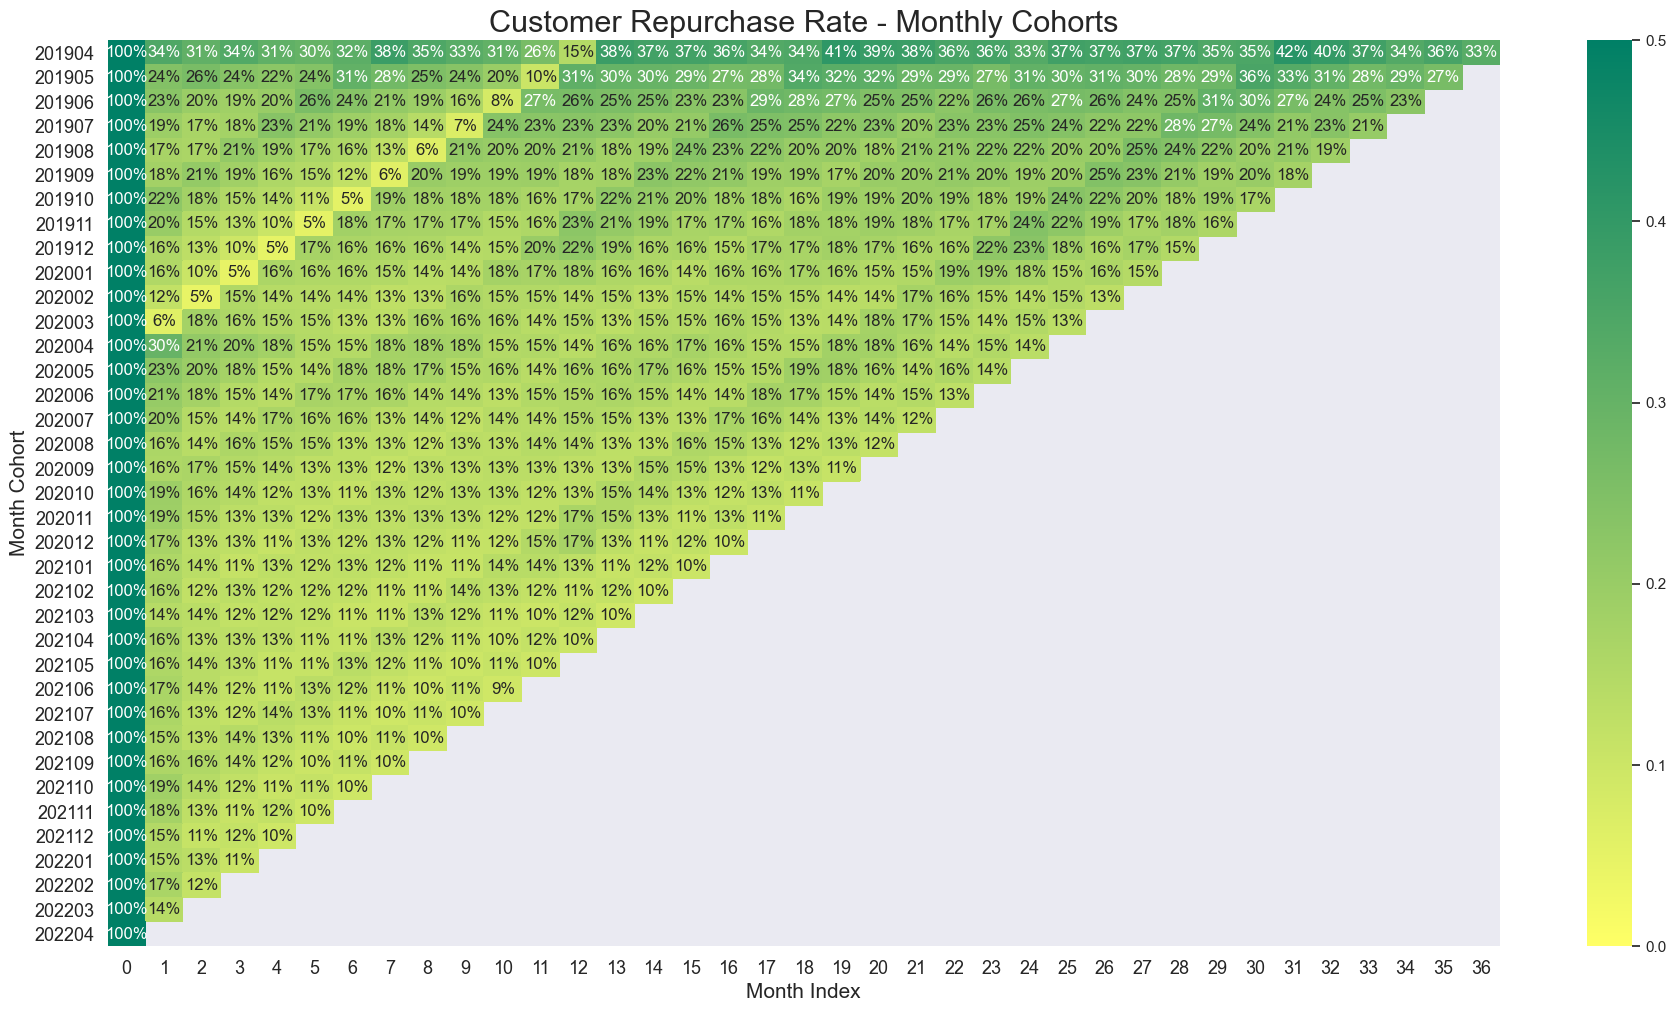

In [333]:
#sns.set()
plt.figure(figsize=(20,12))
plt.title("Customer Repurchase Rate - Monthly Cohorts",fontsize=22)
plot = sns.heatmap(data=cohort_counts,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=0.5,
           cmap="summer_r")
plt.xlabel('Month Index', fontsize = 15)
plt.ylabel('Month Cohort', fontsize = 15)
plot.set_xticklabels(plot.get_xmajorticklabels(),fontsize = 13)
plot.set_yticklabels(plot.get_ymajorticklabels(),fontsize = 13)
plt.show()

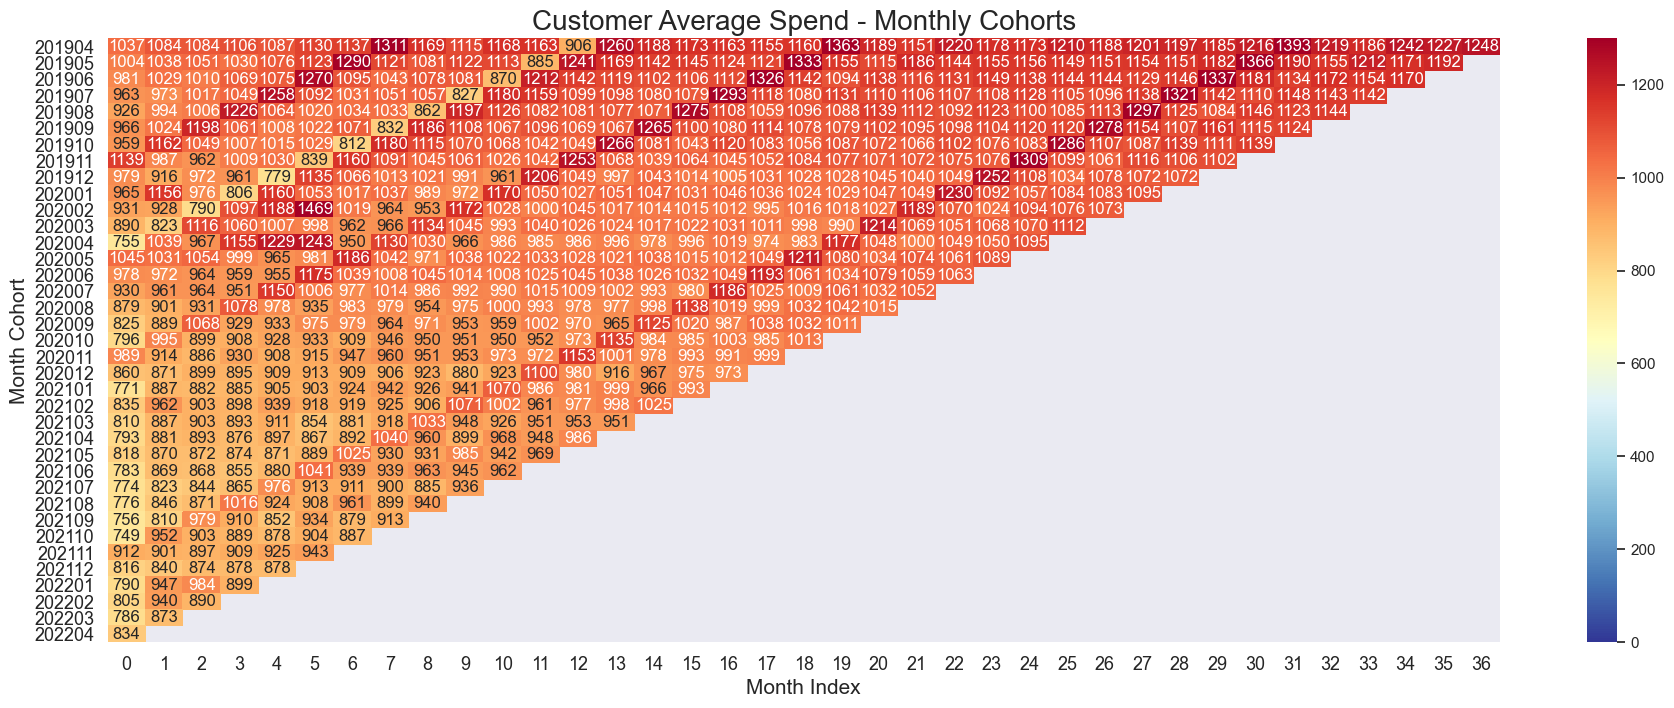

In [236]:
cohort_aov = df2.pivot(index="first_purchase", columns="month_order",values="AOV")
#sns.set()
pd.set_option('display.float_format', lambda s: '%.2f' % s)
plt.figure(figsize=(20,8))
plt.title("Customer Average Spend - Monthly Cohorts",fontsize=20)
plot = sns.heatmap(data=cohort_aov,
           annot=True,
           #fmt='.0%',
           fmt='g',
           vmin=0,
           vmax=1300,
           cmap=plt.cm.RdYlBu_r)
plt.xlabel('Month Index', fontsize = 15)
plt.ylabel('Month Cohort', fontsize = 15)
plot.set_xticklabels(plot.get_xmajorticklabels(),fontsize = 13)
plot.set_yticklabels(plot.get_ymajorticklabels(),fontsize = 13)
plt.show()

In [4]:
device_auth = DeviceCodeLoginAuthentication()
#token_with_device_code = device_auth.get_access_token()

Performing interactive authentication. Please follow the instructions on the terminal.
 To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code DWC8BCNMR to authenticate.
You have logged in.
Interactive authentication successfully completed.


In [232]:
group_id = "f98fd365-8d9a-4316-a357-7521ecb9450a"
report_id = "8df27529-0581-47b1-b22b-34dff40bd5c2"

In [233]:
report = Report(group_id=group_id, report_id=report_id, auth=device_auth)
report

Report()

ConnectionError: HTTPSConnectionPool(host='login.microsoftonline.com', port=443): Max retries exceeded with url: /organizations/v2.0/.well-known/openid-configuration (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000021521BDEAF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

##### Observations

- By looking at customer monthly cohorts it's easier to see the percentage of customers that make a repurchase after x months.
- For example, we can see that 34% of customers that purchased in April 2019 purchased again a month later. 31% of those customers repurchased two months later, 34% repurchased 3 months later etc.
- Overall, we have an average of 18% 1-month repurchase rate. Meaning 18% of our customers make a repurchase every month.
  - 15% 2-month repurchase
  - 14% 3-month repurchase 

- it appears that there has been growth in the number of repeat purchasers and these customers account for 90%+ monthly GMV
- The average spend, order unit and fequency of shopping for repeat purchasers has also been growing especially during FY21. There was also a growth in the new purchasers during FY21
- The Top 20% of customers who account for 80% GMV are repeat purchasers